In [1]:
!nvidia-smi # checking for GPU ver.

Sun Feb  4 05:07:32 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P100-PCIE-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0              24W / 250W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
# %pip install imbalanced-learn
# %pip install lightgbm
# %pip install cuml
# %pip show cuml
# export LDFLAGS="-L/opt/homebrew/opt/libomp/lib"
# export CPPFLAGS="-I/opt/homebrew/opt/libomp/include"


In [3]:
import pandas as pd
import numpy as np
import warnings
from scipy.sparse import vstack
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import ComplementNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
from collections import Counter

/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


In [4]:
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

## Data Preparation

In [5]:
df = pd.read_csv("/kaggle/input/training-data/karthik_cleaned_data.csv", index_col=[0])
df.head()

,overall_rating,review_date,review_text,airline_name,NPS_category,NPS,language_info,clean_text,text_length,word_count,unique_word_count,word_density,uppercase_words,comma_count,exclamation_count,question_mark_count,avg_sentence_length,flesch_reading_score,gunning_fog_index
0,Rated 1 out of 5 stars,2023-09-18 03:29:15,EasyJet sent text at 4.00 am day of flight hom...,easyjet,Detractor,-1,en,text rush organise transport effort implicatio...,194,32,29,5.878788,0,1,0,0,6.600000,81.90,5.06
1,9,2023-12-01 00:00:00,Its been a few years when I flew a lot in A...,Vistara,Promoter,1,en,asia vistara surprise swift immaculate steward...,608,109,74,5.527273,3,7,0,0,27.250000,61.19,14.08
3,Rated 1 out of 5 stars,2018-09-09 20:37:11,one of the worst experiences with Air France e...,air france,Detractor,-1,en,ever bore carry duty inbound,204,30,30,6.580645,0,2,0,0,10.000000,61.33,8.00
4,Rated 1 out of 5 stars,2019-12-23 14:00:19,Not a single star this airlines deserves .I lo...,egyptair,Detractor,-1,en,deserves last block respond mail operator harr...,464,87,64,5.272727,4,2,0,0,14.833333,74.39,7.45
5,Rated 1 out of 5 stars,2023-12-29 06:42:56,I was forced to pay 150-euro worth penalty for...,ryanair,Detractor,-1,en,penalty fail earth would dare season arrogant ...,240,38,35,6.153846,1,1,0,1,12.666667,58.58,10.34


In [6]:
df.isna().sum()

overall_rating            0
review_date               0
review_text               0
airline_name              0
NPS_category              0
NPS                       0
language_info             0
clean_text              719
text_length               0
word_count                0
unique_word_count         0
word_density              0
uppercase_words           0
comma_count               0
exclamation_count         0
question_mark_count       0
avg_sentence_length       0
flesch_reading_score      0
gunning_fog_index         0
dtype: int64

In [7]:
df.dropna(inplace=True)

In [8]:
df["NPS_category"] = df["NPS_category"].map({"Detractor": 0, "Neutral": 1, "Promoter": 2})

### Bag of words

In [9]:
# creating bag of words representation

count_vectorizer = CountVectorizer()
bow_matrix = count_vectorizer.fit_transform(df["clean_text"])

X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(
    bow_matrix, df["NPS_category"], test_size=0.25, random_state=42)

clf_bow = MultinomialNB()
clf_bow.fit(X_train_bow, y_train_bow)
y_pred_bow = clf_bow.predict(X_test_bow)
print("BoW Classification Report:\n", classification_report(y_test_bow, y_pred_bow))

BoW Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.98      0.94     11894
           1       0.07      0.01      0.01       338
           2       0.78      0.47      0.58      1920

    accuracy                           0.89     14152
   macro avg       0.58      0.48      0.51     14152
weighted avg       0.86      0.89      0.87     14152



### TFIDF


In [10]:
# creating a TF-IDF text representation

tfidf_vectorizer = TfidfVectorizer()

tfidf_matrix = tfidf_vectorizer.fit_transform(df["clean_text"])

X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(
    tfidf_matrix, df["NPS_category"], test_size=0.25, random_state=42)

clf_tfidf = MultinomialNB()
clf_tfidf.fit(X_train_tfidf, y_train_tfidf)
y_pred_tfidf = clf_tfidf.predict(X_test_tfidf)
print("TF-IDF Classification Report:\n", classification_report(y_test_tfidf, y_pred_tfidf))

TF-IDF Classification Report:
               precision    recall  f1-score   support

           0       0.85      1.00      0.92     11894
           1       0.00      0.00      0.00       338
           2       0.91      0.08      0.14      1920

    accuracy                           0.85     14152
   macro avg       0.59      0.36      0.35     14152
weighted avg       0.84      0.85      0.79     14152



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Delta Tfidf

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df['clean_text'], df['NPS_category'], test_size=0.25, random_state=42)

tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

class_idfs = []
unique_classes = np.unique(y_train)
for class_idx in unique_classes:
    class_mask = (y_train == class_idx)
    class_docs = X_train[class_mask]
    class_vectorizer = TfidfVectorizer(vocabulary=tfidf_vectorizer.vocabulary_)
    class_tfidf = class_vectorizer.fit_transform(class_docs)
    class_idf = class_vectorizer.idf_
    class_idfs.append(class_idf)

mean_idf = np.mean(class_idfs, axis=0)

delta_idfs = [class_idf - mean_idf for class_idf in class_idfs]

class_to_index = {label: index for index, label in enumerate(unique_classes)}

X_train_delta_tfidf = []
for i, doc in enumerate(X_train_tfidf):
    class_idx = class_to_index[y_train.iloc[i]]
    delta_idf = delta_idfs[class_idx]
    X_train_delta_tfidf.append(doc.multiply(delta_idf))

X_train_delta_tfidf = vstack(X_train_delta_tfidf)

X_test_tfidf = tfidf_vectorizer.transform(X_test)
X_test_delta_tfidf = []
for i, doc in enumerate(X_test_tfidf):
    class_idx = class_to_index[y_test.iloc[i]]
    delta_idf = delta_idfs[class_idx]
    X_test_delta_tfidf.append(doc.multiply(delta_idf))

X_test_delta_tfidf = vstack(X_test_delta_tfidf)

clf = LogisticRegression()
clf.fit(X_train_delta_tfidf, y_train)

y_pred = clf.predict(X_test_delta_tfidf)
print(classification_report(y_test, y_pred))

/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:1380: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


              precision    recall  f1-score   support

           0       0.96      1.00      0.98     11894
           1       1.00      0.12      0.22       338
           2       0.98      0.88      0.93      1920

    accuracy                           0.96     14152
   macro avg       0.98      0.67      0.71     14152
weighted avg       0.96      0.96      0.95     14152



### Delta Tfidf + class weights (Balancing Technique)

In [12]:
count_vectorizer = CountVectorizer()

# Fit and transform the clean_text to create BoW representation
bow_matrix = count_vectorizer.fit_transform(df["clean_text"])

# Split the data into training and testing sets
X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(
    bow_matrix, df["NPS_category"], test_size=0.25, random_state=42, stratify=df["NPS_category"])

# Train the pipeline on the training data

# Initialize the classifier
clf_bow_res = LogisticRegression(class_weight='balanced')
# clf_bow_res = ComplementNB()

# Fit the classifier on the resampled training data
clf_bow_res.fit(X_train_delta_tfidf, y_train)

# Predict on the test set using the trained pipeline
y_pred = clf_bow_res.predict(X_test_delta_tfidf)

# Print the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99     11894
           1       0.94      0.76      0.84       338
           2       0.84      1.00      0.92      1920

    accuracy                           0.97     14152
   macro avg       0.93      0.91      0.91     14152
weighted avg       0.98      0.97      0.97     14152



### Delta Tfidf + random oversampling (Balancing Technique)

In [13]:
# Assuming df["clean_text"] and df["NPS_category"] are already defined

# Initialize CountVectorizer
count_vectorizer = CountVectorizer()

# Fit and transform the clean_text to create BoW representation
bow_matrix = count_vectorizer.fit_transform(df["clean_text"])

# Split the data into training and testing sets
X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(
    bow_matrix, df["NPS_category"], test_size=0.25, random_state=42)

# Initialize RandomOverSampler
ros = RandomOverSampler(random_state=42)

# Apply RandomOverSampler to training data only
X_train_bow_res, y_train_bow_res = ros.fit_resample(X_train_delta_tfidf, y_train)

# Check the class distribution after resampling
print("Class distribution after Random OverSampling:", Counter(y_train_bow_res))

# Initialize the classifier
# clf_bow_res = ComplementNB()
clf_bow_res = LogisticRegression()

# Fit the classifier on the resampled training data
clf_bow_res.fit(X_train_bow_res, y_train_bow_res)

# Predict on the original (non-resampled) testing data
y_pred_bow_res = clf_bow_res.predict(X_test_delta_tfidf)

# Print the classification report
print("BoW Classification Report after Random OverSampling:\n", classification_report(y_test, y_pred_bow_res))

Class distribution after Random OverSampling: Counter({0: 35651, 2: 35651, 1: 35651})
BoW Classification Report after Random OverSampling:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     11894
           1       0.95      0.76      0.84       338
           2       0.87      1.00      0.93      1920

    accuracy                           0.98     14152
   macro avg       0.94      0.91      0.92     14152
weighted avg       0.98      0.98      0.98     14152



/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Delta Tfidf + SMOTE (Balancing Technique)

In [14]:
# Assuming df["clean_text"] and df["NPS_category"] are already defined

# Initialize CountVectorizer
count_vectorizer = CountVectorizer()

# Fit and transform the clean_text to create BoW representation
bow_matrix = count_vectorizer.fit_transform(df["clean_text"])

# Split the data into training and testing sets
X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(
    bow_matrix, df["NPS_category"], test_size=0.25, random_state=42)

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to training data only
X_train_bow_smote, y_train_bow_smote = smote.fit_resample(X_train_delta_tfidf, y_train)

# Initialize the classifier
# clf_bow_smote = ComplementNB()
clf_bow_smote = LogisticRegression()

# Fit the classifier on the resampled training data
clf_bow_smote.fit(X_train_bow_smote, y_train_bow_smote)

# Predict on the original (non-resampled) testing data
y_pred_bow_smote = clf_bow_smote.predict(X_test_delta_tfidf)

# Print the classification report
print("BoW Classification Report after SMOTE:\n", classification_report(y_test, y_pred_bow_smote))

BoW Classification Report after SMOTE:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98     11894
           1       0.54      0.93      0.68       338
           2       0.88      0.99      0.93      1920

    accuracy                           0.96     14152
   macro avg       0.81      0.96      0.87     14152
weighted avg       0.97      0.96      0.97     14152



/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Delta Tfidf + Adasyn (Balancing Technique)

In [15]:
# Assuming df["clean_text"] and df["NPS_category"] are already defined

# Initialize CountVectorizer
count_vectorizer = CountVectorizer()

# Fit and transform the clean_text to create BoW representation
bow_matrix = count_vectorizer.fit_transform(df["clean_text"])

# Split the data into training and testing sets
X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(
    bow_matrix, df["NPS_category"], test_size=0.25, random_state=42)

# Initialize ADASYN
adasyn = ADASYN(random_state=42)

# Apply ADASYN to training data only
X_train_bow_adasyn, y_train_bow_adasyn = adasyn.fit_resample(X_train_delta_tfidf, y_train)

# Initialize the classifier
# clf_bow_adasyn = ComplementNB()
clf_bow_adasyn = LogisticRegression()

# Fit the classifier on the resampled training data
clf_bow_adasyn.fit(X_train_bow_adasyn, y_train_bow_adasyn)

# Predict on the original (non-resampled) testing data
y_pred_bow_adasyn = clf_bow_adasyn.predict(X_test_delta_tfidf)

# Print the classification report
print("BoW Classification Report after ADASYN:\n", classification_report(y_test, y_pred_bow_adasyn))

BoW Classification Report after ADASYN:
               precision    recall  f1-score   support

           0       1.00      0.95      0.98     11894
           1       0.60      0.91      0.72       338
           2       0.84      1.00      0.91      1920

    accuracy                           0.96     14152
   macro avg       0.81      0.95      0.87     14152
weighted avg       0.97      0.96      0.96     14152



/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Modelling


SGD instead of SVM: https://stackoverflow.com/questions/29704231/in-sklearn-what-is-the-difference-between-a-svm-model-with-linear-kernel-and-a-s <br>
Adaboost: https://www.mygreatlearning.com/blog/adaboost-algorithm/ <br>
Catboost: https://www.geeksforgeeks.org/catboost-ml/ <br>
LightGBM: https://www.kdnuggets.com/2022/01/data-scientists-reasons-lightgbm.html <br>
XGBoost: https://medium.com/sfu-cspmp/xgboost-a-deep-dive-into-boosting-f06c9c41349 <br>
Boosting Comparison: https://towardsdatascience.com/how-to-select-between-boosting-algorithm-e8d1b15924f7

In [16]:
from sklearn.linear_model import SGDClassifier
from catboost import Pool, CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgb

models = {
    "Logistic Regression": LogisticRegression(multi_class='multinomial', solver='lbfgs', class_weight='balanced', max_iter=2000),
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced'),
    "SVM (SGD)": SGDClassifier(loss='hinge', class_weight='balanced', max_iter=1000, tol=1e-3),
    "Random Forest": RandomForestClassifier(class_weight='balanced'),
    "XGBoost": XGBClassifier(enable_categorical=True, eval_metric='mlogloss'),
    "AdaBoost+DT": AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1), n_estimators=100),
    "AdaBoost+LR": AdaBoostClassifier(base_estimator=LogisticRegression(multi_class='multinomial',class_weight='balanced',max_iter=1000),n_estimators=100),
    "Catboost": CatBoostClassifier(iterations=500,learning_rate=0.1,depth=6,l2_leaf_reg=3,cat_features=[], auto_class_weights='Balanced',verbose=200, task_type='GPU',devices='0:1'),
    "LightGBM": LGBMClassifier(boosting_type='gbdt', objective='multiclass',  learning_rate=0.09, max_depth=-1, random_state=42, n_estimators=100, device='gpu', gpu_platform_id=0, gpu_device_id=0)
}

def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    return {"Model": name, "Accuracy": accuracy, "Precision": precision, "Recall": recall, "F1 Score": f1}

In [17]:
results = pd.DataFrame()

for name, model in tqdm(models.items(), desc="Evaluating Models"):
    results_row = evaluate_model(name, model, X_train_delta_tfidf, y_train, X_test_delta_tfidf, y_test)
    results = results._append(results_row, ignore_index=True)
    display(results)
    
results

Evaluating Models:   0%|          | 0/9 [00:00<?, ?it/s]

,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.972583,0.976182,0.972583,0.973122


Evaluating Models:  11%|█         | 1/9 [00:04<00:38,  4.87s/it]

,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.972583,0.976182,0.972583,0.973122
1,Decision Tree,0.954777,0.974620,0.954777,0.962509


Evaluating Models:  22%|██▏       | 2/9 [00:12<00:43,  6.22s/it]

,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.972583,0.976182,0.972583,0.973122
1,Decision Tree,0.954777,0.974620,0.954777,0.962509
2,SVM (SGD),0.982193,0.982382,0.982193,0.980512


Evaluating Models:  33%|███▎      | 3/9 [00:12<00:21,  3.57s/it]

,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.972583,0.976182,0.972583,0.973122
1,Decision Tree,0.954777,0.974620,0.954777,0.962509
2,SVM (SGD),0.982193,0.982382,0.982193,0.980512
3,Random Forest,0.980073,0.980090,0.980073,0.978542


Evaluating Models:  44%|████▍     | 4/9 [00:39<01:03, 12.76s/it]

,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.972583,0.976182,0.972583,0.973122
1,Decision Tree,0.954777,0.974620,0.954777,0.962509
2,SVM (SGD),0.982193,0.982382,0.982193,0.980512
3,Random Forest,0.980073,0.980090,0.980073,0.978542
4,XGBoost,0.970322,0.970821,0.970322,0.968711


Evaluating Models:  56%|█████▌    | 5/9 [01:16<01:27, 21.75s/it]

,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.972583,0.976182,0.972583,0.973122
1,Decision Tree,0.954777,0.974620,0.954777,0.962509
2,SVM (SGD),0.982193,0.982382,0.982193,0.980512
3,Random Forest,0.980073,0.980090,0.980073,0.978542
4,XGBoost,0.970322,0.970821,0.970322,0.968711
5,AdaBoost+DT,0.953010,0.953768,0.953010,0.949724


Evaluating Models:  67%|██████▋   | 6/9 [01:32<00:58, 19.59s/it]

,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.972583,0.976182,0.972583,0.973122
1,Decision Tree,0.954777,0.974620,0.954777,0.962509
2,SVM (SGD),0.982193,0.982382,0.982193,0.980512
3,Random Forest,0.980073,0.980090,0.980073,0.978542
4,XGBoost,0.970322,0.970821,0.970322,0.968711
5,AdaBoost+DT,0.953010,0.953768,0.953010,0.949724
6,AdaBoost+LR,0.898954,0.955261,0.898954,0.917976


Evaluating Models:  78%|███████▊  | 7/9 [01:56<00:41, 20.95s/it]

0:	learn: 1.0366557	total: 20.6s	remaining: 2h 51m 12s
200:	learn: 0.3268331	total: 30.1s	remaining: 44.7s
400:	learn: 0.2540758	total: 38.5s	remaining: 9.5s
499:	learn: 0.2297061	total: 42.7s	remaining: 0us


,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.972583,0.976182,0.972583,0.973122
1,Decision Tree,0.954777,0.974620,0.954777,0.962509
2,SVM (SGD),0.982193,0.982382,0.982193,0.980512
3,Random Forest,0.980073,0.980090,0.980073,0.978542
4,XGBoost,0.970322,0.970821,0.970322,0.968711
5,AdaBoost+DT,0.953010,0.953768,0.953010,0.949724
6,AdaBoost+LR,0.898954,0.955261,0.898954,0.917976
7,Catboost,0.900650,0.936764,0.900650,0.909386


Evaluating Models:  89%|████████▉ | 8/9 [02:45<00:29, 29.84s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 192306
[LightGBM] [Info] Number of data points in the train set: 42454, number of used features: 4410
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...


1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score -0.174644
[LightGBM] [Info] Start training from score -3.699631
[LightGBM] [Info] Start training from score -1.998700


/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.972583,0.976182,0.972583,0.973122
1,Decision Tree,0.954777,0.974620,0.954777,0.962509
2,SVM (SGD),0.982193,0.982382,0.982193,0.980512
3,Random Forest,0.980073,0.980090,0.980073,0.978542
4,XGBoost,0.970322,0.970821,0.970322,0.968711
5,AdaBoost+DT,0.953010,0.953768,0.953010,0.949724
6,AdaBoost+LR,0.898954,0.955261,0.898954,0.917976
7,Catboost,0.900650,0.936764,0.900650,0.909386
8,LightGBM,0.978166,0.978414,0.978166,0.977243


Evaluating Models: 100%|██████████| 9/9 [03:06<00:00, 20.68s/it]


,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.972583,0.976182,0.972583,0.973122
1,Decision Tree,0.954777,0.974620,0.954777,0.962509
2,SVM (SGD),0.982193,0.982382,0.982193,0.980512
3,Random Forest,0.980073,0.980090,0.980073,0.978542
4,XGBoost,0.970322,0.970821,0.970322,0.968711
5,AdaBoost+DT,0.953010,0.953768,0.953010,0.949724
6,AdaBoost+LR,0.898954,0.955261,0.898954,0.917976
7,Catboost,0.900650,0.936764,0.900650,0.909386
8,LightGBM,0.978166,0.978414,0.978166,0.977243


## Evaluation

In [18]:
# %pip install pandas==2.0.3

SVD init
SVD finished
logreg init
logreg fit
logreg predict
Accuracy: 0.8194601469756925
              precision    recall  f1-score   support

           0       1.00      0.83      0.91     11894
           1       0.11      0.90      0.19       338
           2       0.98      0.74      0.84      1920

    accuracy                           0.82     14152
   macro avg       0.70      0.82      0.65     14152
weighted avg       0.98      0.82      0.88     14152



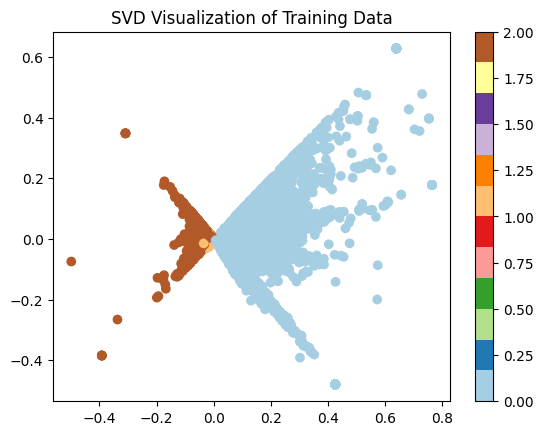

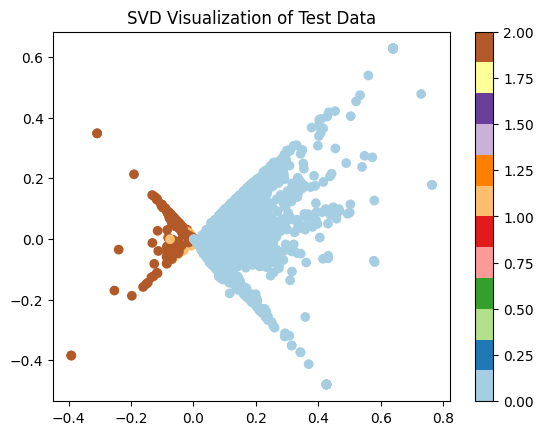

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Assuming you have X_train, X_test, y_train, and y_test defined earlier

# Step 1: Apply Truncated SVD for feature reduction on CPU
n_components = 3  # You can adjust this value as needed
svd = TruncatedSVD(n_components=n_components, random_state=42)
print("SVD init")

# Fit and transform on training data
X_train_svd = svd.fit_transform(X_train_delta_tfidf.toarray())

# Transform on test data
X_test_svd = svd.transform(X_test_delta_tfidf.toarray())
print("SVD finished")

# Step 2: Logistic Regression with class weights for evaluation
logistic_regression = LogisticRegression(class_weight='balanced')
print("logreg init")

# Fit the model
logistic_regression.fit(X_train_svd, y_train)
print("logreg fit")

# Predictions
y_pred = logistic_regression.predict(X_test_svd)
print("logreg predict")

# Step 3: Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Step 4: Visualize SVD results
plt.scatter(X_train_svd[:, 0], X_train_svd[:, 1], c=y_train, cmap=plt.cm.Paired)
plt.colorbar()
plt.title("SVD Visualization of Training Data")
plt.show()

plt.scatter(X_test_svd[:, 0], X_test_svd[:, 1], c=y_test, cmap=plt.cm.Paired)
plt.colorbar()
plt.title("SVD Visualization of Test Data")
plt.show()

In [20]:
# %conda update pandas
# %conda update dask
# %conda update dask-cudf